This notebook will deal with the resampling and comparison of single and multi bat context audio segments. 

### Observed audio split-measurements
Each video annotation was matched with a corresponding length of audio, and each annotation also had the number of bats seen in the video. In the previous notebook ('Split measuring all valid...'), each annotation audio was split into 50ms segments and various measurements were carried out on them (rms, -20dB frequency, dominant frequency). 

### Virtual multi-bat audio split-measurements
The same protocol for the observed audio split-measurements was followed to keep the measurements comparable. The main difference if that the audio analysed here were actually synthetic. The 'virtual' multi bat audio were made by adding two or three duration matched single bat files. This mimics a situation where two bats are echolocating in the recording volume, without showing any response to each other. 


### Reducing the extent of pseudo-replication in the natural observations through bootstrapping

In the current notebook I will now load the previous measurements of segments that had a non-negligible rms (+20dB above the level calculated for silent audio segments). These measurements contain measurement values for multiple segments from the same audio file. Comparing the measurements from all segments together may lead to spurious results because of the extent of pseudo-replication in the data. This is because, not only are the segments from the same audio file, but even many of the audio files are from the same hour. 

Resampling to take out the measurements from one segment per audio file will help reduce the extent of pseudo-replication. 

### Comparisons to be performed
*Update (2020-08-25): in a previous version of this notebook I had calculated $\Delta$median differences between the 3 pairs derived from the three 'groups' we have. After discussion with NMR and HRG, we decided the $\Delta$median is not the most biologically relevant way to present all the data. Different parameters need to be tested with different methods as is relevant. More importantly, it was also decided that it's better to first study the bootstrapped median values before jumping into the $\Delta$median values*

The bootstrapped median values will be calculated for all parameters across all groups. A single window will be chosen from each annotation matched audio file and this will be used to generate the median value. The median value is sensible to compare for certain parameters eg. peak amplitude, rms, lower frequency. For other parameters it is less relevant, eg. dominant frequencies.

For parameters like dominant frequencies, the more relevant question is whether the frequency distributions overlap or not. It is not so much of interest whether the overall median is higher or lower, but rather whether the overall dominant frequency distributions are similar. The question is more holistically focussed. 


In [1]:
import datetime as dt
import os
import sys 
sys.path.append('../')
ind_call_analysis_folder = '../../individual_call_analysis/analysis/'
sys.path.append(ind_call_analysis_folder)
from measure_annot_audio.inbuilt_measurement_functions import dB
from analysis_annotation_audio import make_inspection_and_comparison_plot

from dask.distributed import Client, wait

import matplotlib.pyplot as plt
import numpy as np 
np.random.seed(82325)
import pandas as pd
import scipy.stats 
import tqdm





In [2]:
notebook_dir = os.getcwd()

In [3]:

# %%
# Make the egg for the shuffle_overlap folder
# Install a pip package in the current Jupyter kernel - thanks to 
# https://jakevdp.github.io/blog/2017/12/05/installing-python-packages-from-jupyter/
import os 
os.chdir(ind_call_analysis_folder)

import sys
!{sys.executable}  ../../individual_call_analysis/analysis/setup_shuffleoverlap.py bdist_egg

# switch working directory to the notebook's actual location 
os.chdir(notebook_dir)


running bdist_egg
running egg_info
writing shuffle_overlap.egg-info/PKG-INFO
writing dependency_links to shuffle_overlap.egg-info/dependency_links.txt
writing top-level names to shuffle_overlap.egg-info/top_level.txt
reading manifest file 'shuffle_overlap.egg-info/SOURCES.txt'
writing manifest file 'shuffle_overlap.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/shuffle_overlap
copying build/lib/shuffle_overlap/shuffle_overlap.py -> build/bdist.linux-x86_64/egg/shuffle_overlap
copying build/lib/shuffle_overlap/__init__.py -> build/bdist.linux-x86_64/egg/shuffle_overlap
byte-compiling build/bdist.linux-x86_64/egg/shuffle_overlap/shuffle_overlap.py to shuffle_overlap.cpython-37.pyc
byte-compiling build/bdist.linux-x86_64/egg/shuffle_overlap/__init__.py to __init__.cpython-37.pyc
creating build/bdist.linux-x86_64/egg/EGG-INFO
copying shuffle_overla

In [4]:
client = Client('tcp://192.168.5.147:7890')

# for whatever reason the .egg file upload works better than the .py and .zip upload- so make an egg file. 
client.upload_file(ind_call_analysis_folder+'dist/shuffle_overlap-0.1-py2.7.egg')
from shuffle_overlap import shuffle_overlap

/home/tbeleyur/anaconda2/envs/mhbc/lib/python3.7/site-packages/distributed/client.py:1138: VersionMismatchWarning: Mismatched versions found

+-------------+--------+-----------+--------------------+
| Package     | client | scheduler | workers            |
+-------------+--------+-----------+--------------------+
| cloudpickle | 1.6.0  | 1.6.0     | {'1.5.0', '1.6.0'} |
+-------------+--------+-----------+--------------------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


In [5]:
client

Client Scheduler: tcp://192.168.5.147:7890 Dashboard: http://192.168.5.147:8787/status,Cluster Workers: 3 Cores: 12 Memory: 42.23 GB


In [6]:
%matplotlib notebook

In [7]:
%load_ext line_profiler

In [8]:
split_measure = pd.read_csv('non_silent_measurements_20dBthreshold.csv')
split_measure['type'] = 'observed'

virtual_split_measure = pd.read_csv('non_silent_virtual_multibat_measurements_20dBthreshold.csv')
virtual_split_measure['type'] = 'virtual'

### Adding virtual multibat into the split measure
I will add the virtual multibat files  into a common split measure DataFrame, but also include the 'type' column to prevent confusion. 

In [9]:
all_measures = pd.concat([split_measure, virtual_split_measure]).reset_index(drop=True)

# a stupid hack to fix the pairing order in a deterministic way. 
# Among the three pairs possible, the order is always the following
# single-observed
# multi-observed
# multi-virtual

group_and_type = []
for i, row in all_measures.iterrows():
    row_type = row['type']
    num_bats = row['num_bats']
    if num_bats>1:
        single_or_multi = '1multi'
    else:
        single_or_multi = '0single'
    
    group_and_type.append(single_or_multi + '_' + row_type)

all_measures['group_type'] = group_and_type

In [10]:
np.unique(group_and_type)

array(['0single_observed', '1multi_observed', '1multi_virtual'],
      dtype='<U16')

In [11]:
all_measures.head()

,Unnamed: 0,value,segment_number,measurement,file_name,unique_window_id,video_annot_id,num_bats,type,group_type
0,0,0.032661,0,rms,matching_annotaudio_Aditya_2018-08-16_21502300...,0_matching_annotaudio_Aditya_2018-08-16_215023...,Aditya_2018-08-16_21502300_9,1,observed,0single_observed
1,1,0.102295,0,peak_amplitude,matching_annotaudio_Aditya_2018-08-16_21502300...,0_matching_annotaudio_Aditya_2018-08-16_215023...,Aditya_2018-08-16_21502300_9,1,observed,0single_observed
2,2,90200.000000,0,minus_XdB_frequency,matching_annotaudio_Aditya_2018-08-16_21502300...,0_matching_annotaudio_Aditya_2018-08-16_215023...,Aditya_2018-08-16_21502300_9,1,observed,0single_observed
3,3,104700.000000,0,dominant_frequencies,matching_annotaudio_Aditya_2018-08-16_21502300...,0_matching_annotaudio_Aditya_2018-08-16_215023...,Aditya_2018-08-16_21502300_9,1,observed,0single_observed
4,4,0.020559,3,rms,matching_annotaudio_Aditya_2018-08-16_21502300...,3_matching_annotaudio_Aditya_2018-08-16_215023...,Aditya_2018-08-16_21502300_12,2,observed,1multi_observed


In [12]:
split_measure.head()

,Unnamed: 0,value,segment_number,measurement,file_name,unique_window_id,video_annot_id,num_bats,type
0,0,0.032661,0,rms,matching_annotaudio_Aditya_2018-08-16_21502300...,0_matching_annotaudio_Aditya_2018-08-16_215023...,Aditya_2018-08-16_21502300_9,1,observed
1,1,0.102295,0,peak_amplitude,matching_annotaudio_Aditya_2018-08-16_21502300...,0_matching_annotaudio_Aditya_2018-08-16_215023...,Aditya_2018-08-16_21502300_9,1,observed
2,2,90200.000000,0,minus_XdB_frequency,matching_annotaudio_Aditya_2018-08-16_21502300...,0_matching_annotaudio_Aditya_2018-08-16_215023...,Aditya_2018-08-16_21502300_9,1,observed
3,3,104700.000000,0,dominant_frequencies,matching_annotaudio_Aditya_2018-08-16_21502300...,0_matching_annotaudio_Aditya_2018-08-16_215023...,Aditya_2018-08-16_21502300_9,1,observed
4,4,0.020559,3,rms,matching_annotaudio_Aditya_2018-08-16_21502300...,3_matching_annotaudio_Aditya_2018-08-16_215023...,Aditya_2018-08-16_21502300_12,2,observed


In [13]:
virtual_split_measure.head()

,Unnamed: 0,value,segment_number,measurement,file_name,unique_window_id,video_annot_id,num_bats,type
0,0,0.032842,0,rms,matching_annotaudio_Aditya_2018-08-17_01_29_hp...,0_matching_annotaudio_Aditya_2018-08-17_01_29_...,Aditya_2018-08-17_01_29,2,virtual
1,1,0.123779,0,peak_amplitude,matching_annotaudio_Aditya_2018-08-17_01_29_hp...,0_matching_annotaudio_Aditya_2018-08-17_01_29_...,Aditya_2018-08-17_01_29,2,virtual
2,2,99980.000000,0,minus_XdB_frequency,matching_annotaudio_Aditya_2018-08-17_01_29_hp...,0_matching_annotaudio_Aditya_2018-08-17_01_29_...,Aditya_2018-08-17_01_29,2,virtual
3,3,104480.000000,0,dominant_frequencies,matching_annotaudio_Aditya_2018-08-17_01_29_hp...,0_matching_annotaudio_Aditya_2018-08-17_01_29_...,Aditya_2018-08-17_01_29,2,virtual
4,4,0.018701,1,rms,matching_annotaudio_Aditya_2018-08-17_01_29_hp...,1_matching_annotaudio_Aditya_2018-08-17_01_29_...,Aditya_2018-08-17_01_29,2,virtual


### Number of segments per annotation


In [14]:
by_audio_file = all_measures.groupby(['file_name'])

all_window_counts = []
for filename, df in by_audio_file:
    df_rms = df[df['measurement']=='rms']
    num_windows = df_rms.shape[0]
    all_window_counts.append(num_windows)

summary_counts = np.percentile(all_window_counts, [0,25,50, 75,100])
print(summary_counts)

[ 1.  3.  6. 11. 86.]


<IPython.core.display.Javascript object>


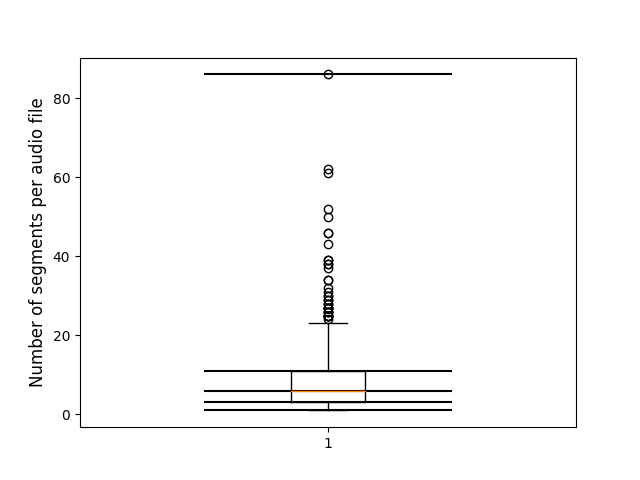

In [15]:
plt.figure()
plt.boxplot(all_window_counts); plt.ylabel('Number of segments per audio file', fontsize=12)
plt.hlines(summary_counts, 0.75, 1.25)

The four black lines represent the minimum, first quartile, median, third quartile and the maximum. As can be the seen the minimum is 1 segment per file, while the general norm is between 3 to 10 segments per file. There are also some files with upto more than 20 segments too!!! Without accounting for the difference in segments contributed by each file, the results may just be biased by how many segments each audio file contributes.

### A broad look at parameters across group-sizes, does the data look okay?

In [16]:
by_seg = all_measures.groupby(['segment_number'])
by_seg.get_group(0).reset_index(drop=True)

,Unnamed: 0,value,segment_number,measurement,file_name,unique_window_id,video_annot_id,num_bats,type,group_type
0,0,0.032661,0,rms,matching_annotaudio_Aditya_2018-08-16_21502300...,0_matching_annotaudio_Aditya_2018-08-16_215023...,Aditya_2018-08-16_21502300_9,1,observed,0single_observed
1,1,0.102295,0,peak_amplitude,matching_annotaudio_Aditya_2018-08-16_21502300...,0_matching_annotaudio_Aditya_2018-08-16_215023...,Aditya_2018-08-16_21502300_9,1,observed,0single_observed
2,2,90200.000000,0,minus_XdB_frequency,matching_annotaudio_Aditya_2018-08-16_21502300...,0_matching_annotaudio_Aditya_2018-08-16_215023...,Aditya_2018-08-16_21502300_9,1,observed,0single_observed
3,3,104700.000000,0,dominant_frequencies,matching_annotaudio_Aditya_2018-08-16_21502300...,0_matching_annotaudio_Aditya_2018-08-16_215023...,Aditya_2018-08-16_21502300_9,1,observed,0single_observed
4,15,0.045400,0,rms,matching_annotaudio_Aditya_2018-08-16_21502300...,0_matching_annotaudio_Aditya_2018-08-16_215023...,Aditya_2018-08-16_21502300_18,2,observed,1multi_observed
...,...,...,...,...,...,...,...,...,...,...
1695,8367,105220.000000,0,dominant_frequencies,matching_annotaudio_Aditya_2018-08-17_34_133_h...,0_matching_annotaudio_Aditya_2018-08-17_34_133...,Aditya_2018-08-17_34_133,2,virtual,1multi_virtual
1696,8368,105480.000000,0,dominant_frequencies,matching_annotaudio_Aditya_2018-08-17_34_133_h...,0_matching_annotaudio_Aditya_2018-08-17_34_133...,Aditya_2018-08-17_34_133,2,virtual,1multi_virtual
1697,8369,105740.000000,0,dominant_frequencies,matching_annotaudio_Aditya_2018-08-17_34_133_h...,0_matching_annotaudio_Aditya_2018-08-17_34_133...,Aditya_2018-08-17_34_133,2,virtual,1multi_virtual
1698,8370,106220.000000,0,dominant_frequencies,matching_annotaudio_Aditya_2018-08-17_34_133_h...,0_matching_annotaudio_Aditya_2018-08-17_34_133...,Aditya_2018-08-17_34_133,2,virtual,1multi_virtual


### Peak amplitude

<IPython.core.display.Javascript object>


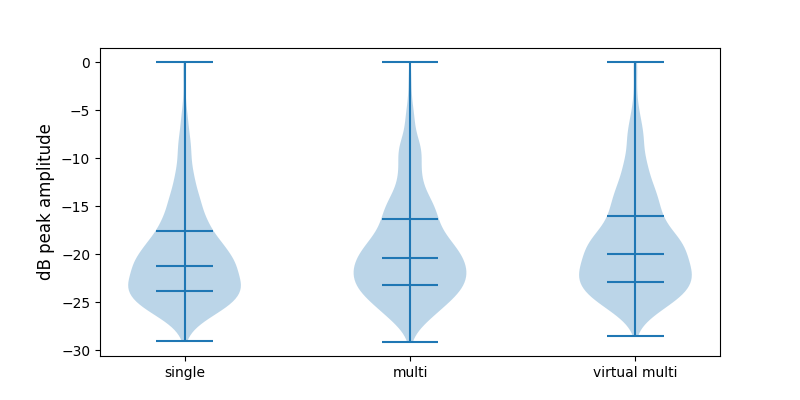

Text(0, 0.5, 'dB peak amplitude')

In [17]:
make_inspection_and_comparison_plot(all_measures, 'peak_amplitude', dB)
plt.ylabel('dB peak amplitude')

### RMS

<IPython.core.display.Javascript object>


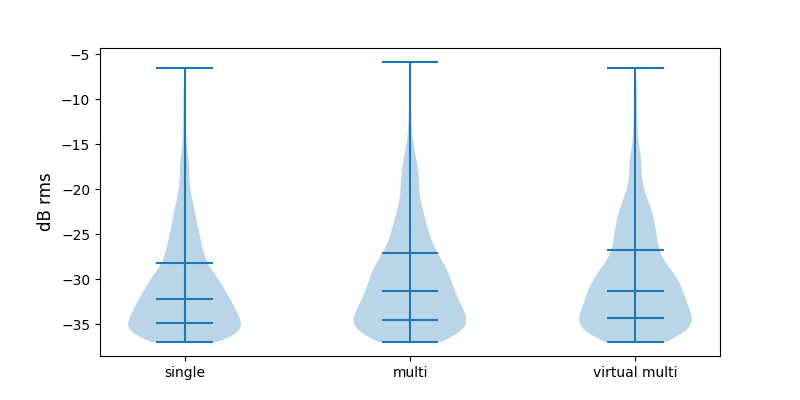

Text(0, 0.5, 'dB rms')

In [18]:
make_inspection_and_comparison_plot(all_measures, 'rms', dB)
plt.ylabel('dB rms')

### Dominant frequencies

<IPython.core.display.Javascript object>


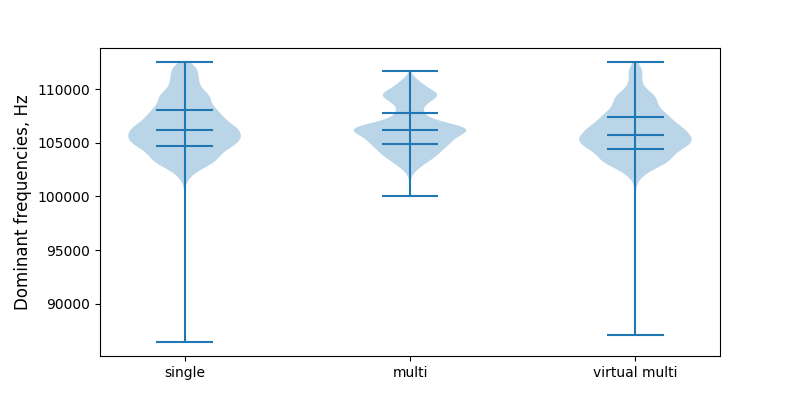

Text(0, 0.5, 'Dominant frequencies, Hz')

In [19]:
make_inspection_and_comparison_plot(all_measures, 'dominant_frequencies')
plt.ylabel('Dominant frequencies, Hz')

### Lower frequency (-46 dB of peak frequency)

<IPython.core.display.Javascript object>


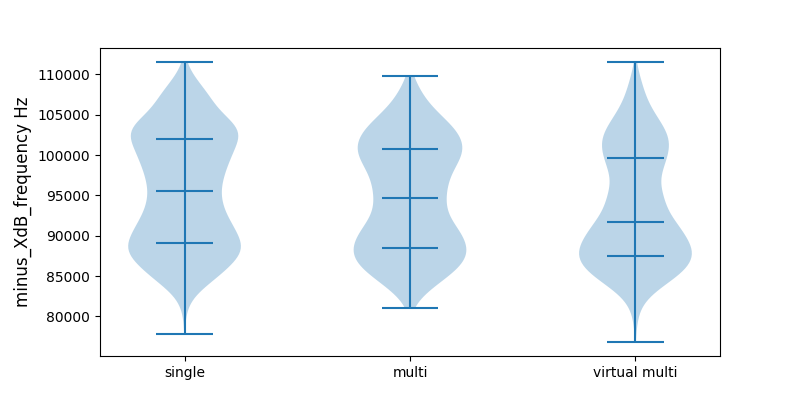

Text(0, 0.5, 'minus_XdB_frequency Hz')

In [20]:
make_inspection_and_comparison_plot(all_measures, 'minus_XdB_frequency')
plt.ylabel('minus_XdB_frequency Hz')

## Calculate the bootstrapped medians for all the relevant parameters across the three group sizes



### Using Dask to perform distributed computing

0. Activate the conda/virtual environment

1. open a terminal window, activate conda environment, and type 

```$ dask-scheduler --port 7890```

2. Copy the tcp address
3. Open another terminal window on this computer, activate conda environment and then type

```$ dask-worker tcp://<ipaddress of dask-scheduler window> --nanny-port 7891```

4. Now move to all of the other computers you would like to use and 
5. open terminal/CMD with the same version of dask, pandas and numpy installed and now type

``` $ dask-worker tcp://<ipaddress shown on dask-worker window> --nanny-port 7891```

*Remember, it's important to install the **same** python and all dependent package version across all worker computers - or you can get error messages about incompatibilities*

#### Ensure the environments are the same across all computers

The scheduler computer in my case is an Ubuntu 18.04, and the workers include 3 Windows 10 computers + this computer itself. 

I found that dask works best when installed with ```conda install dask```. However, this option overrides the previous package versions installed that are important for this notebook (numpy and pandas). To get the working environments back to the previous versions - use the ```pip install pandas==VERSIONUMBER1 numpy==VERSIONNMUMBER2 --force-reinstall ``` command. This will uninstall the current versions and reinstall the required versions for each package. 




In [21]:
client

Client Scheduler: tcp://192.168.5.147:7890 Dashboard: http://192.168.5.147:8787/status,Cluster Workers: 3 Cores: 12 Memory: 42.23 GB


In [22]:
def calculate_bootstrapped_median_across_grouptypes(df, measurement_name, summary_fn,proc_fn):
    '''
    A DataFrame with 2 group types is taken, bootstrapped and the delta median 
    between the two group types is repeatedly calculated
    
    
    Returns
    -------
    median_data : 
    '''
    one_segment = resample_one_segment_from_each_audio(df)
    group123_measures = calc_group_type_summary(one_segment, 
                                                          measurement_name, 
                                                      summary_fn, proc_fn)
    median_data = [ np.median(each) for each in group123_measures]
    
    return median_data

def resample_one_segment_from_each_audio(df):
    '''
    Parameters
    ----------
    df : pd.DataFrame
        DataFrame with the following compulsory columns
        file_name, segment_number
    Returns 
    -------
    one_seg_per_file : pd.DataFrame
        A subset of all rows, but with only one segment per file chosen. 
    '''
    by_filename = df.groupby(['file_name'])
    #resampled_data = [choose_one_segment(each) for each in by_filename]
    resampled_data = by_filename.apply(choose_one_segment)
    one_seg_per_file = resampled_data.reset_index(drop=True)
    return one_seg_per_file

def choose_one_segment(sub_df):
    #filename, sub_df = filename_and_subdf
    # if there are >1 valid segments in the audio file, then select just one randomly
    segments = sub_df['segment_number'].tolist()
    if len(segments) == 1:
        return sub_df
    else:
        one_segment = int(np.random.choice(segments, 1))
        chosen_rows = sub_df['segment_number']==one_segment
        return sub_df[chosen_rows]
    
def calc_group_type_summary(df, measurement_name, summary_fn, proc_fun:lambda X:X):
    '''
    Splits the df into three groups based on the column 'group_type'. 
    If there are more than two group types, then an error is raised
    
    '''
    
    df_bygrouptype = split_into_grouptypes(df)
    if len(df_bygrouptype)!=3:
        raise ValueError('There must be 3 group types for this analysis')
    df_grouptypes = [each[each['measurement']==measurement_name]  for each in df_bygrouptype]
    
    summary_grouptypes = [summary_fn(proc_fun(each_df['value'])) for each_df in df_grouptypes] 
    summary1, summary2, summary3 = summary_grouptypes
    return summary1, summary2, summary3

def split_into_grouptypes(df):
    '''
    splits the dataframes by group type
    '''
    group_types = np.unique(df['group_type'])
    return [df[df['group_type']==each] for each in group_types]

def just_return_input(X):
    return X
dB = lambda X : 20*np.log10(X)

In [23]:
np.unique(all_measures['group_type'])

array(['0single_observed', '1multi_observed', '1multi_virtual'],
      dtype=object)

In [24]:
by_grps = split_into_grouptypes(all_measures)

In [25]:
by_grps[2]['group_type']

19254    1multi_virtual
19255    1multi_virtual
19256    1multi_virtual
19257    1multi_virtual
19258    1multi_virtual
              ...      
27823    1multi_virtual
27824    1multi_virtual
27825    1multi_virtual
27826    1multi_virtual
27827    1multi_virtual
Name: group_type, Length: 8574, dtype: object

In [26]:
import time

In [27]:
def  reshape_to_3_cols(X):
    return np.array(X).reshape(-1,3)

In [35]:
calculation_futures = {}
calculation_futures['dbrms'] = []
calculation_futures['dbpeak'] = []
calculation_futures['lowerfreq'] = []

all_median_results = {}

start = time.time()

total_runs = 100

scattered_data = client.scatter(all_measures, broadcast=True) # send the DataFrame to all the workers

for i in tqdm.trange(total_runs):
    # dB RMS
    dbrms_bootmed = client.submit(calculate_bootstrapped_median_across_grouptypes,
                          scattered_data, 
                             measurement_name='rms',summary_fn=just_return_input,proc_fn=dB, pure=False)
    calculation_futures['dbrms'].append(dbrms_bootmed)
wait(calculation_futures['dbrms'])
raw_dbrms = client.gather(calculation_futures['dbrms'])
all_median_results['dbrms'] = reshape_to_3_cols(raw_dbrms)


for i in tqdm.trange(total_runs):
    #db peak
    dbpeak_bootmed = client.submit(calculate_bootstrapped_median_across_grouptypes,
                             scattered_data, 
                             measurement_name='peak_amplitude',
                             summary_fn=just_return_input,
                             proc_fn=dB, pure=False)
    calculation_futures['dbpeak'].append(dbpeak_bootmed)
wait(calculation_futures['dbpeak'])
all_median_results['dbpeak'] = reshape_to_3_cols(client.gather(calculation_futures['dbpeak']))


for i in tqdm.trange(total_runs):

    # lower frequency
    lowerfreq_med = client.submit(calculate_bootstrapped_median_across_grouptypes,
                                  scattered_data,measurement_name='minus_XdB_frequency',
                                  summary_fn=just_return_input, 
                                  proc_fn=just_return_input, 
                                  pure=False)
    calculation_futures['lowerfreq'].append(lowerfreq_med)


wait(calculation_futures['lowerfreq'])
all_median_results['lowerfreq'] = reshape_to_3_cols(client.gather(calculation_futures['lowerfreq']))

end = time.time()-start

print(f'Execution time is {end}')

100%|██████████| 100/100 [00:00<00:00, 595.40it/s]


Execution time is 137.45167994499207


In [39]:
all_median_results['dbrms'][:10,:]

array([[-33.47253573, -32.55008615, -32.18681362],
       [-33.32771179, -33.343005  , -31.44019322],
       [-33.56977724, -32.9988815 , -31.98826901],
       [-33.47670744, -31.76128146, -32.06076869],
       [-33.5887789 , -32.0843222 , -31.6923841 ],
       [-33.53097562, -32.80592416, -31.57444702],
       [-33.87490695, -32.38128757, -31.92615206],
       [-33.28483838, -32.34777203, -31.31659099],
       [-33.44065278, -32.77299043, -30.82701208],
       [-33.63273195, -32.48173706, -31.70415774]])

In [37]:
raw_dbrms 
#all_median_results['dbrms'] 

[[-33.47253573293627, -32.550086145682144, -32.18681362468218],
 [-33.327711788177, -33.343004996635266, -31.440193222239028],
 [-33.56977723560676, -32.9988814958111, -31.988269011921787],
 [-33.476707439079505, -31.761281457163427, -32.06076869224401],
 [-33.58877890412347, -32.08432220394329, -31.69238409747175],
 [-33.53097561982948, -32.80592415837539, -31.574447015707644],
 [-33.874906948630105, -32.38128757479976, -31.92615205508084],
 [-33.28483838324597, -32.34777203319837, -31.316590989821684],
 [-33.440652778135295, -32.77299043460607, -30.82701207659658],
 [-33.63273194984168, -32.481737061310525, -31.704157744376612],
 [-33.10122978620497, -32.58160916845325, -31.849550276801388],
 [-33.444670723497964, -32.65934618384688, -32.18681362468218],
 [-33.5117658999232, -32.340013466003114, -31.043213326280238],
 [-33.60308056200508, -32.58613289591762, -31.508182414116618],
 [-33.444670723497964, -33.343004996635266, -31.193038211816383],
 [-33.16425138972985, -32.5268777086125

<IPython.core.display.Javascript object>


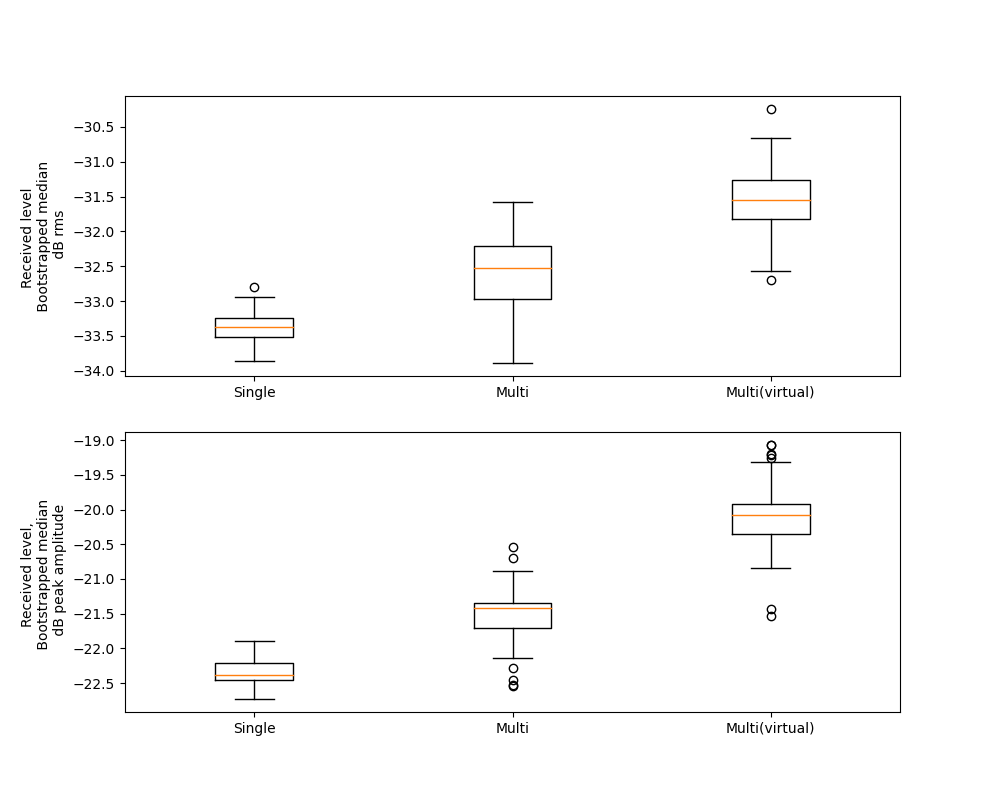

([<matplotlib.axis.XTick at 0x7f57c045ca20>,
 [Text(0, 0, 'Single'), Text(0, 0, 'Multi'), Text(0, 0, 'Multi(virtual)')])

In [29]:
xlab_median_plot = lambda X: plt.xticks([1,2,3],['Single','Multi','Multi(virtual)'])

plt.figure(figsize=(10,8))
a0=plt.subplot(211)
plt.boxplot(all_median_results['dbrms']);
plt.ylabel('Received level \n Bootstrapped median \n dB rms')
xlab_median_plot(0)
plt.subplot(212)
plt.boxplot(all_median_results['dbpeak'])
plt.ylabel('Received level, \n Bootstrapped median  \n dB peak amplitude')
xlab_median_plot(0)

<IPython.core.display.Javascript object>


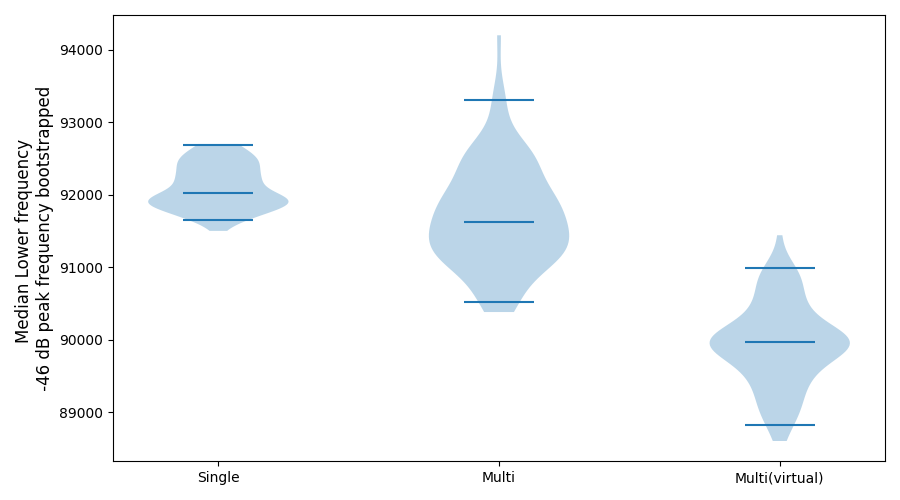

([<matplotlib.axis.XTick at 0x7f57c03cbac8>,
 [Text(0.5, 0, 'Single'),
  Text(1.0, 0, 'Multi'),
  Text(1.5, 0, 'Multi(virtual)')])

In [30]:
plt.figure(figsize=(9,5))
plt.violinplot(all_median_results['lowerfreq'],
               showmedians=True,
                  quantiles=[[0.025,0.975],[0.025,0.975],[0.025,0.975],],
              showextrema=False);
plt.ylabel('Median Lower frequency \n -46 dB peak frequency bootstrapped ', fontsize=12)
plt.tight_layout()
xlab_median_plot(0)

The bootstrapped median lower frequency for single and multi bat situations are within ~500 Hz of each other, while the virtual multi lower frequency seems to trend towards being even lower. Where is this decrease in lower frequency coming from. By itself I find it hard to explain, and can only think of the possibility that this is a result of this batch of file combinations used to make the virtual multi audio files. Perhaps an overlap analysis will throw some more light on how different virtual multi audio is from the observed single and multi bat audio.

### How to do the overlap analysis exactly?
For single calls, the overlap analysis was fairly straightforward because for each parameter, the observed overlap was compared with the shuffled overlap. In the annotation audio split-measure dataset, it's important to :

- Calculate observed overlap between groups 
- Select one window per audio file for all the data groups involved
- Generate the bootstrapped distribution 


In [31]:

def extract_single_multi_virtualmulti_by_measurement(df, measurement_name):
    '''
    '''
    by_measurements = df[df['measurement']==measurement_name].reset_index(drop=True)
    single, multi, virtual_multi = split_into_single_multi_and_virtual(by_measurements)
    return single, multi, virtual_multi
    
def split_into_single_multi_and_virtual(df):
    '''
    Splits all split-measurements into single, multi and virtual multi bat 
    DataFrames.
    '''
    single_bat = df[df['num_bats']==1].reset_index(drop=True)
    
    real_multi_bat = np.logical_and(df['num_bats']>1, df['type']=='observed')
    multi_bat  = df[real_multi_bat].reset_index(drop=True)
    virtual_multi_bat = np.logical_and(df['num_bats']>1, df['type']=='virtual')
    virtual_multibat = df[virtual_multi_bat]
    return single_bat, multi_bat, virtual_multibat



def shuffle_values_between_grouptypes(df1, df2, measurement_name):
    '''
    '''
    df1_measure, df2_measure = [each[each['measurement']==measurement_name] for each in [df1, df2]]
    df1_rows, df2_rows = df1.shape[0], df2.shape[0]
    # swap values between single and multi bat annotations
    all_values = np.concatenate([df1_measure['value'], df2_measure['value']]).flatten()
    np.random.shuffle(all_values)
    df1['value'] = all_values[:df1_rows]
    df2['value'] = all_values[df1_rows:]
    return df1, df2
    
def bootstrapped_observed_overlap(df, measurement, **kwargs):
    '''
    Returns
    -------
    single_multi, multi_virtualmulti, single_virtualmulti : float
        3 values which correspond to the chosen overlap metric between the three pairs of groups. 
    '''
    single_multi_virtual_multi = extract_single_multi_virtualmulti_by_measurement(df, measurement)
    one_segment_per_file = [ resample_one_segment_from_each_audio(each) for each in single_multi_virtual_multi]
    
    # overlap single-multi
    single_multi,_ = shuffle_overlap.calculate_overlap(one_segment_per_file[0]['value'],
                                                     one_segment_per_file[1]['value'], **kwargs)
    # overlap multi-virtualmulti
    multi_virtualmulti,_ = shuffle_overlap.calculate_overlap(one_segment_per_file[1]['value'], 
                                                           one_segment_per_file[2]['value'], **kwargs)
    # overlap single-virtualmulti
    single_virtualmulti,_ = shuffle_overlap.calculate_overlap(one_segment_per_file[0]['value'], 
                                                           one_segment_per_file[2]['value'], **kwargs)
    return single_multi, multi_virtualmulti, single_virtualmulti

def bootstrapped_shuffled_overlap(df, measurement, **kwargs):
    '''
    '''
    single_multi_virtual_multi = extract_single_multi_virtualmulti_by_measurement(df, measurement)
    one_segment_per_file = [ resample_one_segment_from_each_audio(each) for each in single_multi_virtual_multi]
    
    # shuffle single-multi
    shuffled_single, shuffled_multi = shuffle_values_between_grouptypes(single_multi_virtual_multi[0],
                                                                       single_multi_virtual_multi[1],
                                                                       measurement)
    # overlap single-multi
    shuf_single_multi,_ = shuffle_overlap.calculate_overlap(shuffled_single['value'],
                                                     shuffled_multi['value'], **kwargs)

    # -----------------------------------------------------------------------------------------
    # shuffle multi-virtualmulti
    shuffled_multi, shuffled_virtualmulti = shuffle_values_between_grouptypes(single_multi_virtual_multi[1],
                                                                       single_multi_virtual_multi[2],
                                                                       measurement)
    # overlap multi-virtualmulti
    shuf_multi_virtualmulti,_ = shuffle_overlap.calculate_overlap(shuffled_multi['value'], 
                                                             shuffled_virtualmulti['value'], **kwargs)
    # -----------------------------------------------------------------------------------------
    
    # shuffle single-virtualmulti
    shuffled_single, shuffled_virtualmulti = shuffle_values_between_grouptypes(single_multi_virtual_multi[0],
                                                                       single_multi_virtual_multi[2],
                                                                       measurement)
    
    # overlap single-virtualmulti
    shuf_single_virtualmulti,_ = shuffle_overlap.calculate_overlap(shuffled_single['value'], 
                                                           shuffled_virtualmulti['value'], **kwargs)
    return shuf_single_multi, shuf_multi_virtualmulti, shuf_single_virtualmulti
    
    



In [32]:
start  = time.time()

future_bootstrapped_overlaps = []
future_bootstrapped_shuf_overlaps = []

for i in tqdm.trange(total_runs):
    future_obs_overlap = client.submit(bootstrapped_observed_overlap,scattered_data, 
                                                'minus_XdB_frequency', 
                                                 bin_width=200,
                                                 overlap_method='hellinger',
                                                 pmf=True, pure=False)
    future_bootstrapped_overlaps.append(future_obs_overlap)

    future_shuf_overlap = client.submit(bootstrapped_shuffled_overlap, scattered_data,
                                                       'minus_XdB_frequency',
                                                       bin_width=200,
                                                       overlap_method='hellinger',
                                                       pmf=True, pure=False)
    future_bootstrapped_shuf_overlaps.append(future_shuf_overlap)

wait(future_bootstrapped_overlaps)
wait(future_bootstrapped_shuf_overlaps)

print(f'Time taken for this cell was: {time.time()-start}')

100%|██████████| 100/100 [00:00<00:00, 753.78it/s]


Time taken for this cell was: 86.31615018844604


In [33]:
bootstrapped_overlaps = np.array(client.gather(future_bootstrapped_overlaps))
shuf_overlaps = np.array(client.gather(future_bootstrapped_shuf_overlaps))

<IPython.core.display.Javascript object>


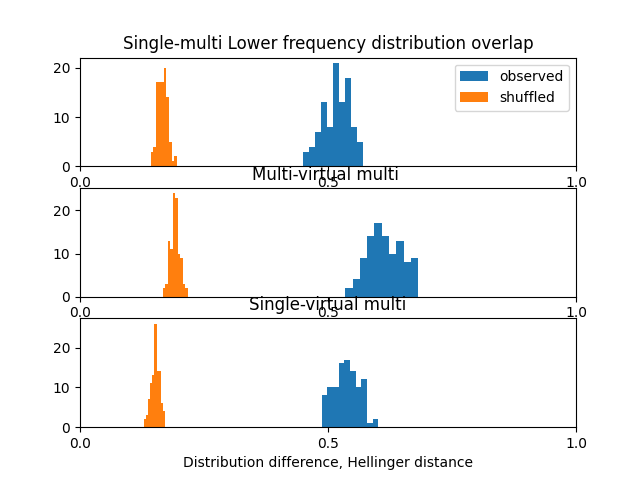

Text(0.5, 0, 'Distribution difference, Hellinger distance')

In [34]:
plt.figure()
a0 =plt.subplot(311)
plt.title('Single-multi Lower frequency distribution overlap')
plt.hist(bootstrapped_overlaps[:,0], label='observed')
plt.hist(shuf_overlaps[:,0], label='shuffled')
plt.xlim(0,1)
plt.xticks([])
plt.legend()
plt.subplot(312, sharex=a0)
plt.title('Multi-virtual multi ')
plt.hist(bootstrapped_overlaps[:,1], label='Bootstrapped observed distribution distance')
plt.hist(shuf_overlaps[:,1], label='Bootstrapped shuffled distribution distance')
a2 = plt.subplot(313, sharex=a0)
plt.title('Single-virtual multi')
plt.hist(bootstrapped_overlaps[:,2], label='Bootstrapped observed distribution distance')
plt.hist(shuf_overlaps[:,2], label='Bootstrapped shuffled distribution distance')
a2.set_xticks([0,0.5,1])
a2.set_xlabel('Distribution difference, Hellinger distance')